In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(3)
limit_mem()

In [5]:
preddir = '/home/rasp/data/myWeatherBench/predictions/'

In [6]:
valdir = '/data/stephan/WeatherBench/5.625deg/'

In [7]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [8]:
exp_ids = ['83-resnet_d3_6h', '84-resnet_d3_1d', '85-resnet_d3_2d', '81-resnet_d3_dr_0.1', 
           '86-resnet_d3_4d', '71-resnet_d3_best_5d']
lead_times = [6, 24, 48, 72, 96, 120]

In [130]:
scores = []
for exp_id in exp_ids:
    print(exp_id)
    args = load_args(f'../nn_configs/B/{exp_id}.yml')
    mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
    std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
    args['ext_mean'] = mean
    args['ext_std'] = std
    dg_test = load_data(**args, only_test=True)
    model = keras.models.load_model(f'/home/rasp/data/myWeatherBench/predictions/saved_models/{exp_id}.h5',
                               custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})
    
    preds = create_predictions(model, dg_test)
    preds.to_netcdf(f'{args["pred_save_dir"]}/{exp_id}_fixed.nc')
    scores.append(
        compute_weighted_rmse(
            preds, 
            valid
        ).load()
    )

83-resnet_d3_6h
DG start 10:49:47.935043
DG normalize 10:49:47.972715
DG load 10:49:47.992029
Loading data into RAM
DG done 10:49:55.918491
84-resnet_d3_1d
DG start 10:50:34.984514
DG normalize 10:50:35.019445
DG load 10:50:35.028207
Loading data into RAM
DG done 10:50:42.957425
85-resnet_d3_2d
DG start 10:51:22.960213
DG normalize 10:51:22.997482
DG load 10:51:23.006755
Loading data into RAM
DG done 10:51:30.958936
81-resnet_d3_dr_0.1
DG start 10:52:11.837919
DG normalize 10:52:11.877740
DG load 10:52:11.886860
Loading data into RAM
DG done 10:52:19.981738
86-resnet_d3_4d
DG start 10:53:00.725533
DG normalize 10:53:00.762863
DG load 10:53:00.772877
Loading data into RAM
DG done 10:53:08.702176
71-resnet_d3_best_5d
DG start 10:53:49.878245
DG normalize 10:53:49.911514
DG load 10:53:49.920341
Loading data into RAM
DG done 10:54:02.262282


In [15]:
scores = []
for exp_id in exp_ids:
    
    preds = xr.open_dataset(f'{args["pred_save_dir"]}/{exp_id}_fixed.nc')
    scores.append(
        compute_weighted_rmse(
            preds, 
            valid
        ).load()
    )

In [16]:
rmse_direct = xr.concat(scores, dim=lead_times)

In [17]:
rmse_direct.to_netcdf('./rmse_direct.nc')

In [164]:
preds_direct = [xr.open_dataset(f'{args["pred_save_dir"]}/{exp_id}_fixed.nc') for exp_id in exp_ids]

In [53]:
rmse = xr.open_dataset('/data/stephan/WeatherBench/baselines/rmse_5.625.nc')

In [25]:
rmse

<xarray.Dataset>
Dimensions:               (lead_time: 29)
Coordinates:
  * lead_time             (lead_time) int64 0 6 12 18 24 ... 144 150 156 162 168
    level                 int32 ...
    lev                   float64 ...
Data variables:
    z_persistence         (lead_time) float64 ...
    t_persistence         (lead_time) float64 ...
    z_climatology         float64 1.075e+03
    t_climatology         float64 ...
    z_weekly_climatology  float64 815.7
    t_weekly_climatology  float64 ...
    z_lr_6h_iter          (lead_time) float64 ...
    t_lr_6h_iter          (lead_time) float64 ...
    z_lr_3d               float64 ...
    t_lr_3d               float64 ...
    z_lr_5d               float64 ...
    t_lr_5d               float64 ...
    z_cnn_6h_iter         (lead_time) float64 ...
    t_cnn_6h_iter         (lead_time) float64 ...
    z_cnn_3d              float64 ...
    t_cnn_3d              float64 ...
    z_cnn_5d              float64 ...
    t_cnn_5d              float64 ...
    t_tigge               (lead_time) float64 ...
    z_tigge               (lead_time) float64 ...
    z_t42                 (lead_time) float64 ...
    t_t42                 (lead_time) float64 ...

In [30]:
ds_raw = xr.open_dataset('/data/stephan/Weyn/forecast_dlwp-cs-s2s_4var-t850_UNET2.1_WeatherBench.nc')

In [37]:
ds = regrid(ds_raw, ddeg_out=5.625)

Reuse existing file: bilinear_91x180_32x64_peri.nc
using dimensions ('lat', 'lon') from data variable z500 as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z500 as the horizontal dimensions for this dataset.


In [38]:
ds = ds.rename({'f_hour': 'lead_time', 'z500': 'z', 't850': 't'})

In [160]:
preds_weyn = ds

In [39]:
rmse_weyn = evaluate_iterative_forecast(ds, valid).load()

In [40]:
rmse_weyn

<xarray.Dataset>
Dimensions:    (lead_time: 56)
Coordinates:
  * lead_time  (lead_time) float64 6.0 12.0 18.0 24.0 ... 324.0 330.0 336.0
Data variables:
    z_rmse     (lead_time) float64 103.2 122.1 136.1 ... 1.039e+03 1.044e+03
    t_rmse     (lead_time) float64 1.038 1.159 1.222 1.295 ... 4.453 4.46 4.48

In [54]:
t63 = xr.open_dataset('/data/stephan/WeatherBench/baselines/t63_5.625deg.nc')

In [55]:
t63_rmse = evaluate_iterative_forecast(t63, valid).load().rename({'z_rmse': 'z_t63', 't_rmse': 't_t63'})

In [56]:
rmse = xr.merge([rmse, t63_rmse])

In [103]:
rmse.to_netcdf('./baseline_rmses.nc')

In [105]:
rmse_weyn.to_netcdf('./weyn_rmse.nc')

In [106]:
rmse_weyn.sel(lead_time=[72, 120])

<xarray.Dataset>
Dimensions:    (lead_time: 2)
Coordinates:
  * lead_time  (lead_time) float64 72.0 120.0
Data variables:
    z_rmse     (lead_time) float64 373.4 611.3
    t_rmse     (lead_time) float64 1.979 2.868

In [13]:
rmse_cont = xr.open_dataset('./rmse_cont.nc')
rmse_cont_rmse = xr.open_dataset('./rmse_cont_rmse.nc')
rmse_baseline = xr.open_dataset('./baseline_rmses.nc')
rmse_weyn = xr.open_dataset('./weyn_rmse.nc')

(0, 336)

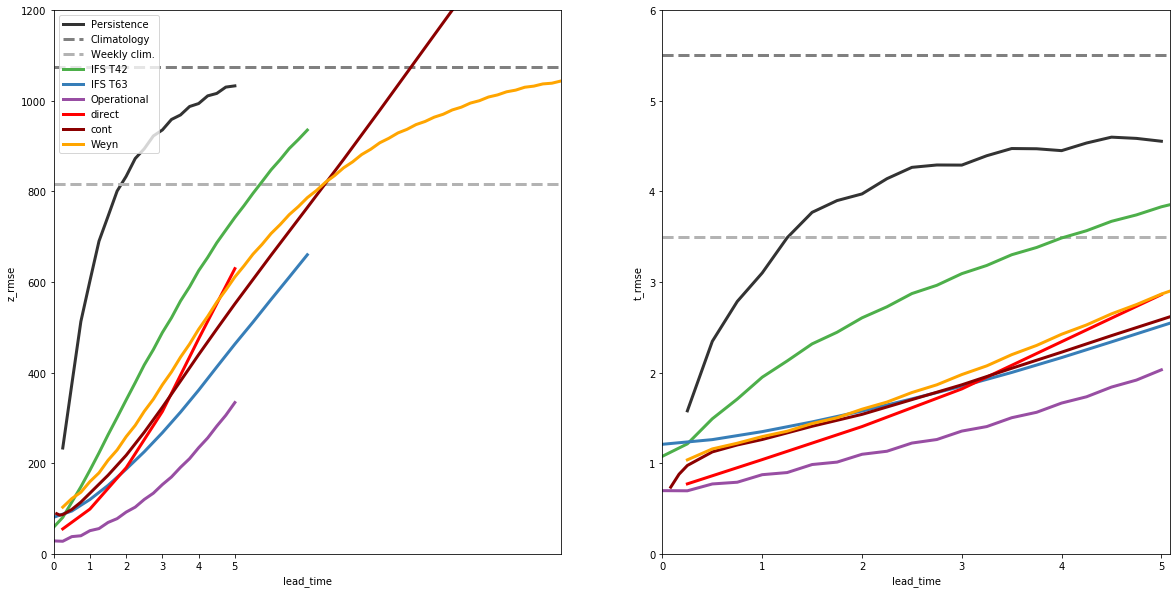

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_rmses(rmse_baseline, 'z', ax=ax1)
plot_rmses(rmse_baseline, 't', ax=ax2)
rmse_direct.z_rmse.plot(ax=ax1, lw=3, c='red', label='direct')
rmse_direct.t_rmse.plot(ax=ax2, lw=3, c='red')
rmse_cont.z_rmse.plot(ax=ax1, lw=3, c='darkred', label='cont')
rmse_cont.t_rmse.plot(ax=ax2, lw=3, c='darkred')
# rmse_cont_rmse.z_rmse.plot(ax=ax1, lw=3, c='darkred', ls='--', label='cont_rmse')
# rmse_cont_rmse.t_rmse.plot(ax=ax2, lw=3, c='darkred', ls='--')
rmse_weyn.z_rmse.plot(ax=ax1, lw=3, c='orange', label='Weyn')
rmse_weyn.t_rmse.plot(ax=ax2, lw=3, c='orange')
ax1.legend(loc=2, ncol=1, fontsize=10)
ax1.set_xlim(0, 336)

In [150]:
rmse_direct2 = []
for exp_id in exp_ids:
    rmse_direct2.append(
        compute_weighted_rmse(
            xr.open_dataset(f'{preddir}/{exp_id}_fixed.nc'), 
            valid,
            mean_dims=['time']
        ).load()
    )

In [151]:
lt = xr.DataArray(lead_times, dims={'lead_time': lead_times}, name='lead_time')

In [152]:
rmse_direct2 = xr.concat(rmse_direct2, dim=lt)

In [65]:
rmse_weyn2 = evaluate_iterative_forecast(ds, valid, mean_dims=['time']).load()

In [143]:
preds_cont = xr.open_dataset('./preds_cont.nc')

In [145]:
rmse_cont2 = evaluate_iterative_forecast(preds_cont, valid, compute_weighted_rmse, mean_dims=['time']).load()

In [79]:
import cartopy.crs as ccrs

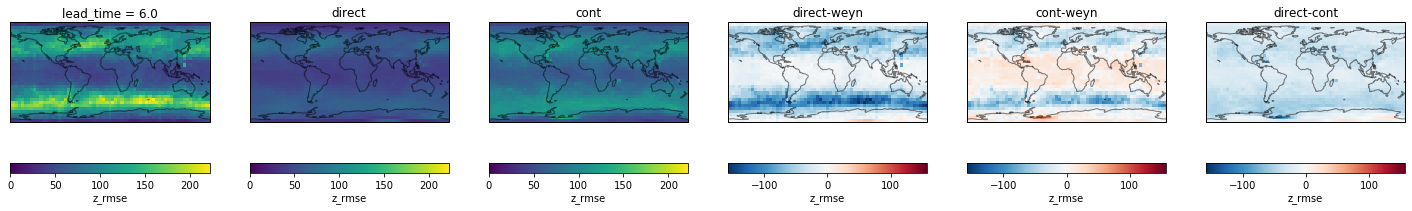

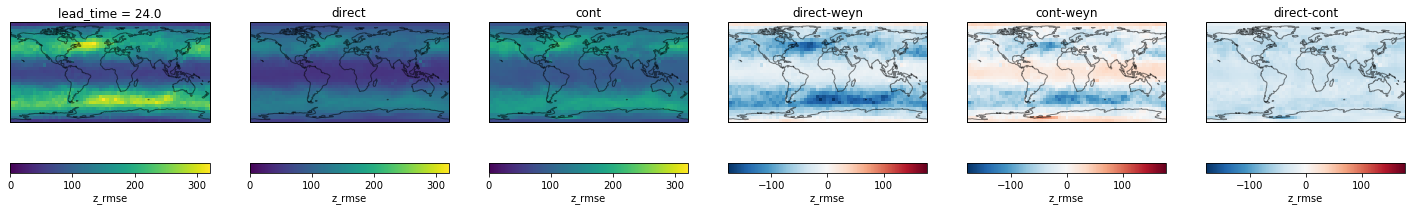

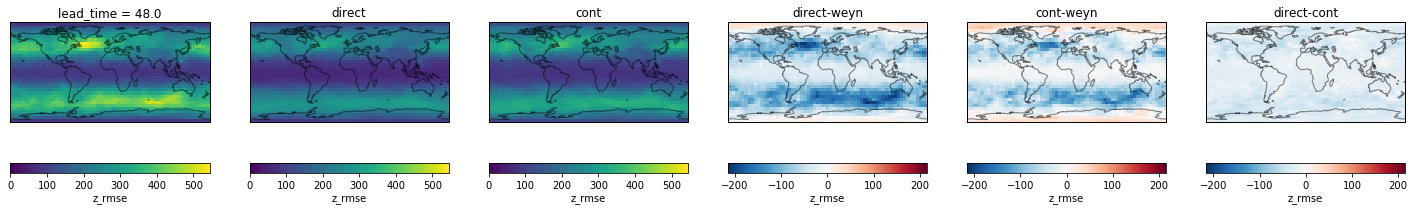

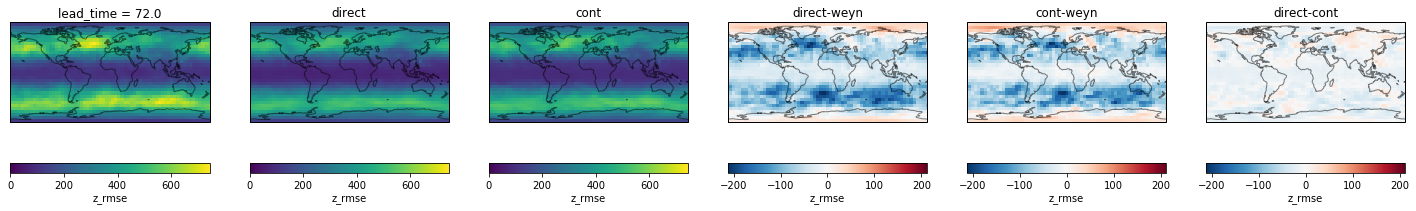

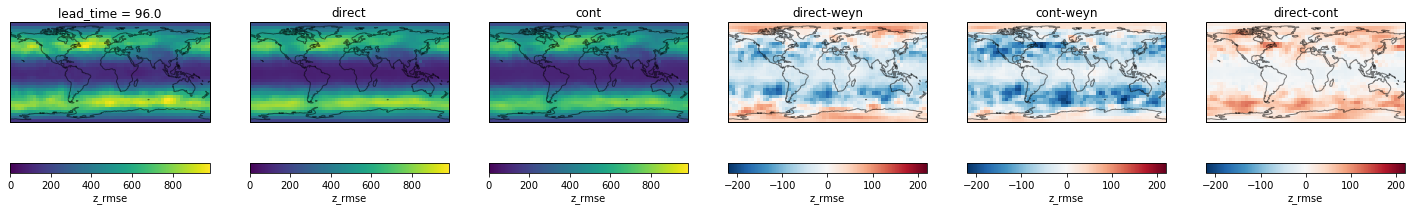

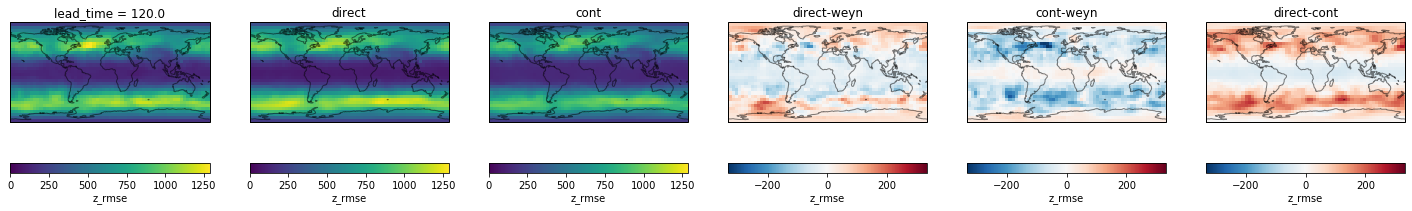

In [204]:
var = 'z_rmse'
for l, p in zip(lead_times, preds2):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(25, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    m = np.max([p[var].max(), rmse_weyn2.sel(lead_time=l)[var].max()])
    rmse_weyn2.sel(lead_time=l)[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    rmse_direct2.sel(lead_time=l)[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    rmse_cont2.sel(lead_time=l)[var].plot(ax=ax3, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    diff_direct = rmse_direct2.sel(lead_time=l)[var] - rmse_weyn2.sel(lead_time=l)[var]
    diff_cont = rmse_cont2.sel(lead_time=l)[var] - rmse_weyn2.sel(lead_time=l)[var]
    diff3 = rmse_direct2.sel(lead_time=l)[var] - rmse_cont2.sel(lead_time=l)[var]
    m = np.max([np.abs(d).max() for d in [diff_direct, diff_cont, diff3]])
    diff_direct.plot(ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    diff_cont.plot(ax=ax5, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    diff3.plot(ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.coastlines(alpha=0.5)
    ax2.set_title('direct')
    ax3.set_title('cont')
    ax4.set_title('direct-weyn')
    ax5.set_title('cont-weyn')
    ax6.set_title('direct-cont')

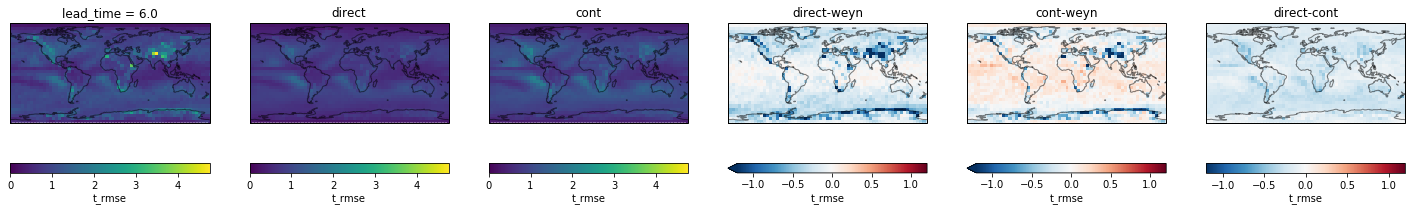

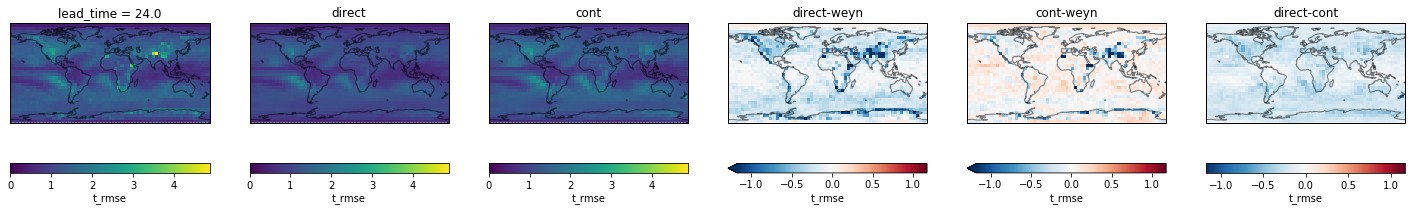

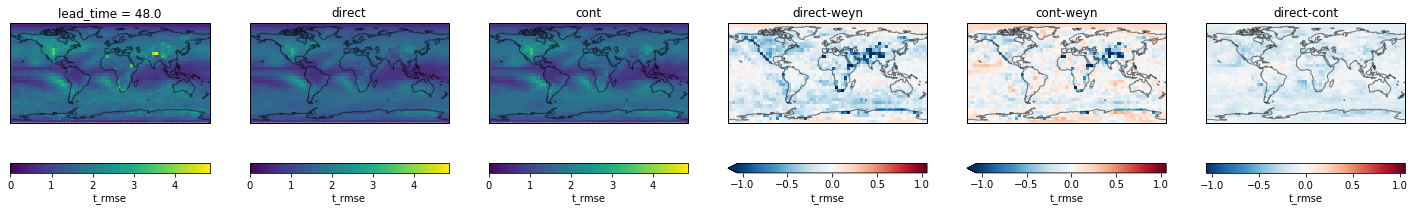

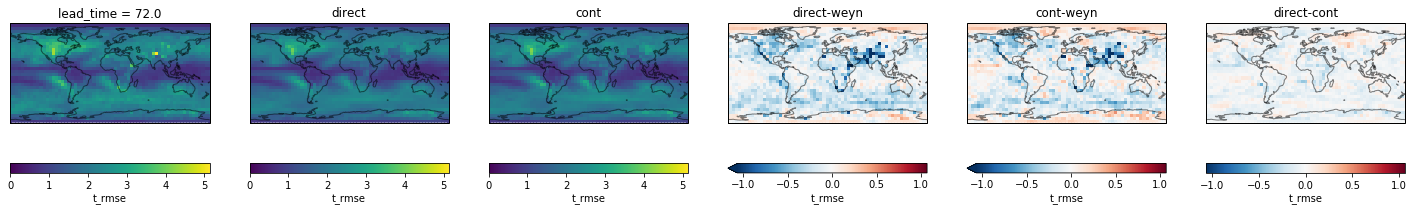

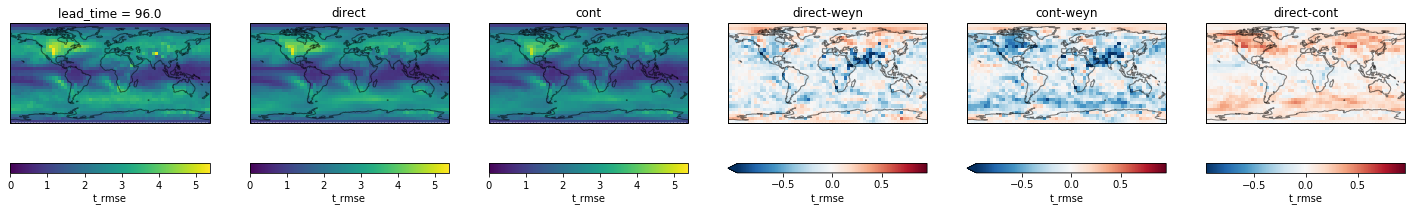

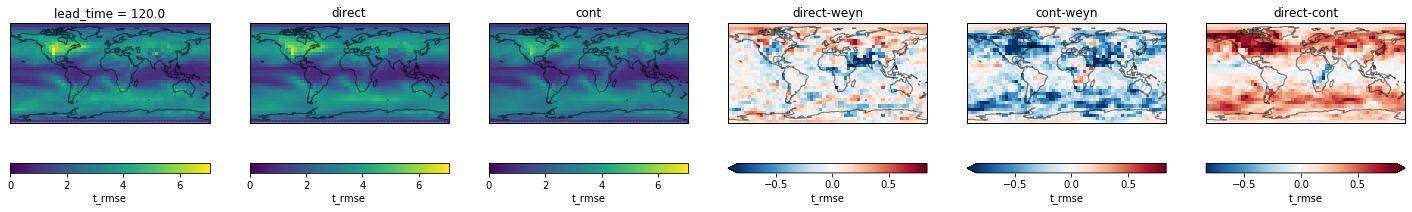

In [207]:
var = 't_rmse'
for l, p in zip(lead_times, preds2):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(25, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    m = np.max([p[var].max(), rmse_weyn2.sel(lead_time=l)[var].max()])
    rmse_weyn2.sel(lead_time=l)[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    rmse_direct2.sel(lead_time=l)[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    rmse_cont2.sel(lead_time=l)[var].plot(ax=ax3, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    diff_direct = rmse_direct2.sel(lead_time=l)[var] - rmse_weyn2.sel(lead_time=l)[var]
    diff_cont = rmse_cont2.sel(lead_time=l)[var] - rmse_weyn2.sel(lead_time=l)[var]
    diff3 = rmse_direct2.sel(lead_time=l)[var] - rmse_cont2.sel(lead_time=l)[var]
    m = np.max([np.abs(d).max() for d in [diff_direct, diff_cont, diff3]]) * 0.3
    diff_direct.plot(ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    diff_cont.plot(ax=ax5, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    diff3.plot(ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.coastlines(alpha=0.5)
    ax2.set_title('direct')
    ax3.set_title('cont')
    ax4.set_title('direct-weyn')
    ax5.set_title('cont-weyn')
    ax6.set_title('direct-cont')

In [223]:
init_time = preds_weyn.time[10].values
lt_idx = -1
lt = lead_times[lt_idx]
valid_time = init_time + np.timedelta64(lt, 'h')
init_time, valid_time, lt, lt_idx

(numpy.datetime64('2017-01-18T00:00:00.000000000'),
 numpy.datetime64('2017-01-23T00:00:00.000000000'),
 120,
 -1)

In [224]:
valid_time

numpy.datetime64('2017-01-23T00:00:00.000000000')

6
24
48
72
96
120


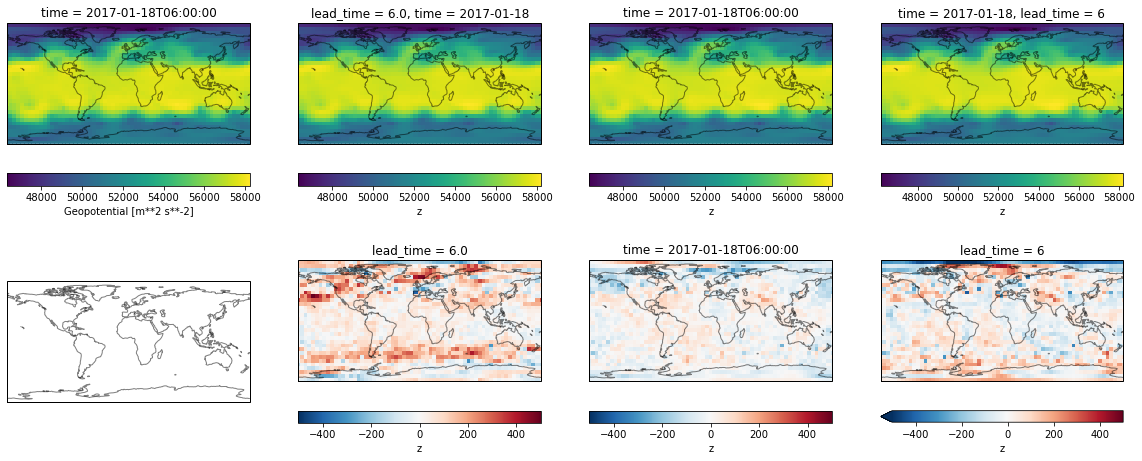

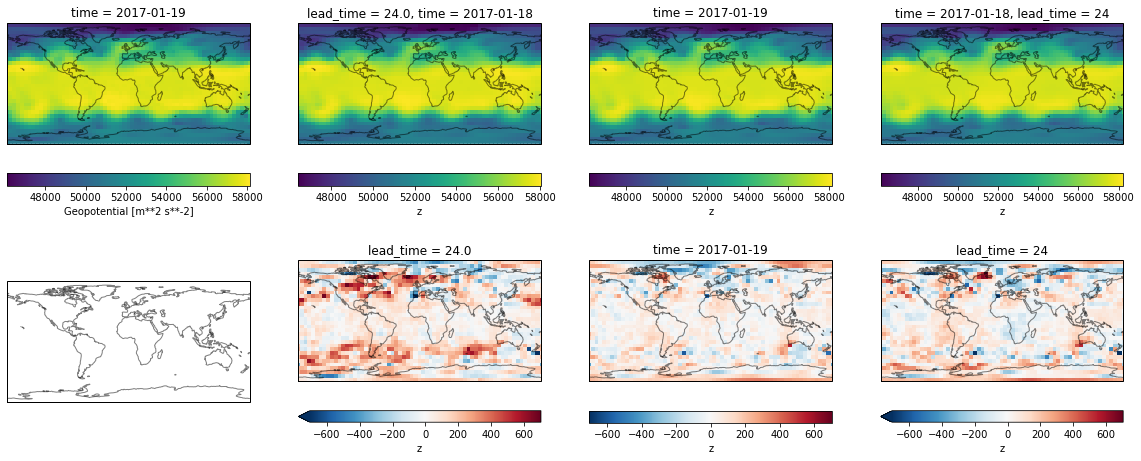

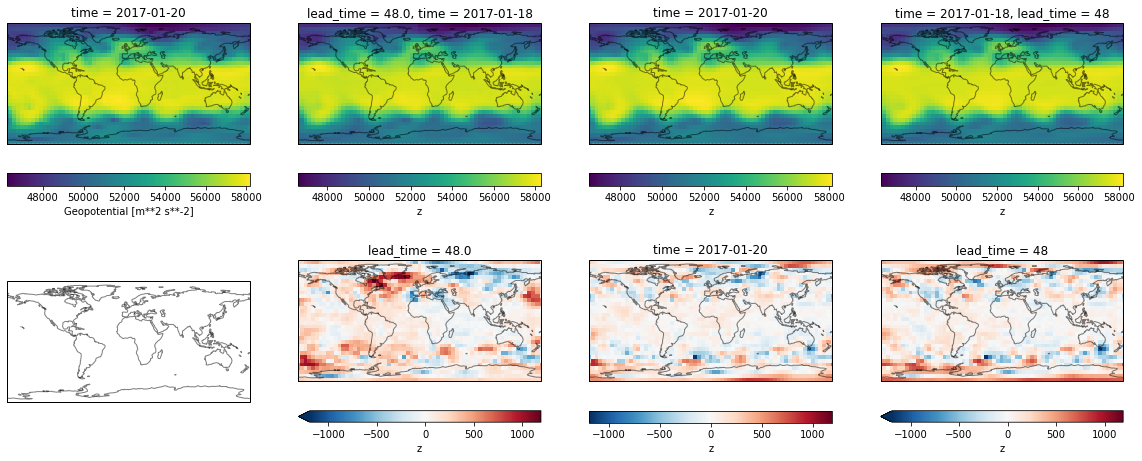

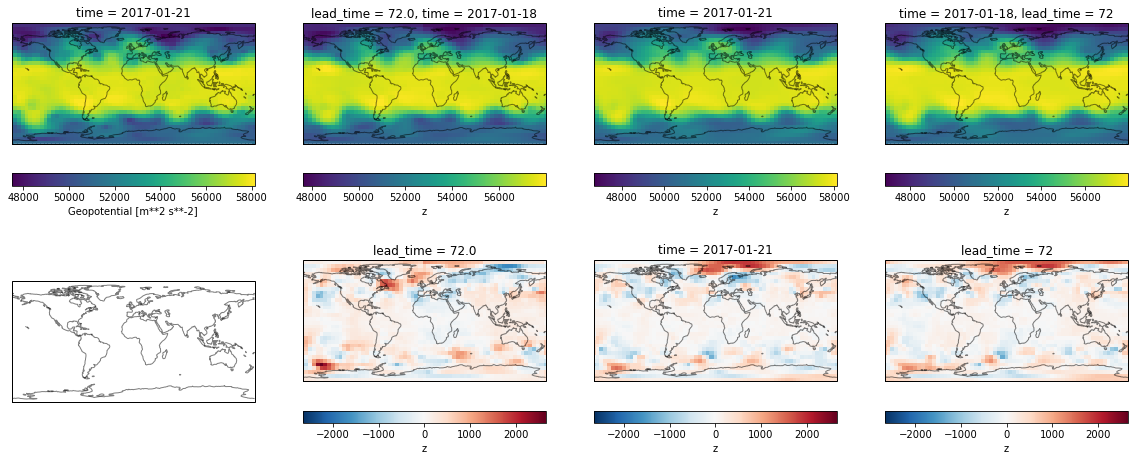

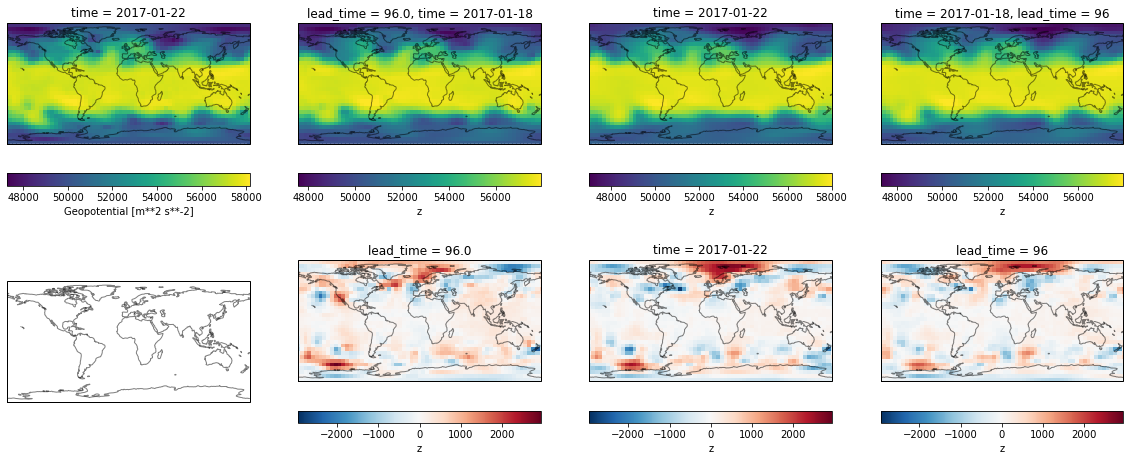

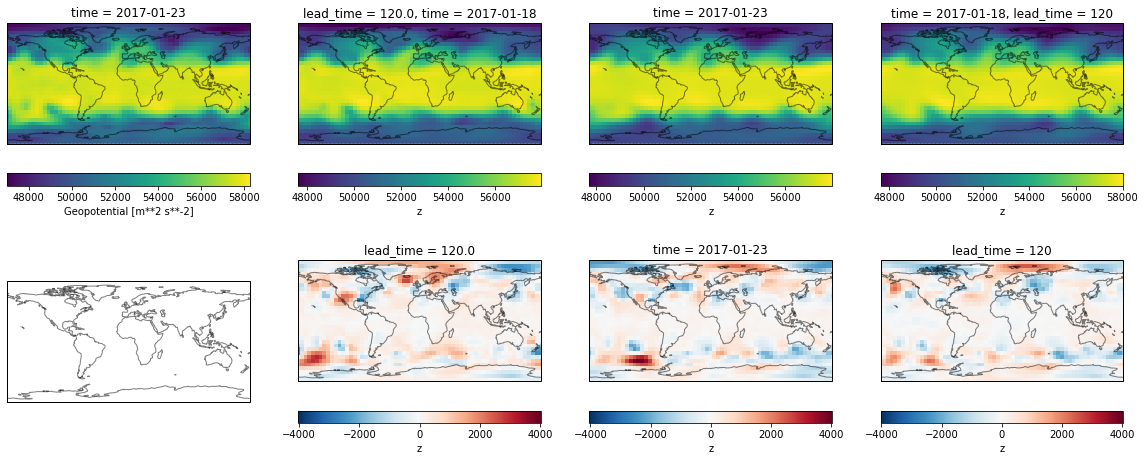

In [228]:
for lt_idx, lt in enumerate(lead_times):
    print(lt)
    valid_time = init_time + np.timedelta64(lt, 'h')
    init_time, valid_time, lt, lt_idx
    var = 'z'
    fig, axs = plt.subplots(2, 4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = axs.flatten()
    valid.sel(time=valid_time)[var].plot(ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    preds_weyn.sel(time=init_time, lead_time=lt)[var].plot(ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    preds_direct[lt_idx].sel(time=valid_time)[var].plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    preds_cont.sel(time=init_time, lead_time=lt)[var].plot(ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})

    e1 = valid.sel(time=valid_time)[var] - preds_weyn.sel(time=init_time, lead_time=lt)[var]
    e2 = valid.sel(time=valid_time)[var] - preds_direct[lt_idx].sel(time=valid_time)[var]
    e3 = valid.sel(time=valid_time)[var] - preds_cont.sel(time=init_time, lead_time=lt)[var]
    m = np.max([e1.max(), e2.max(), e3.max()])
    e1.plot(ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    e2.plot(ax=ax7, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    e3.plot(ax=ax8, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')

    for ax in axs.flatten():
            ax.coastlines(alpha=0.5)

6
24
48
72
96
120


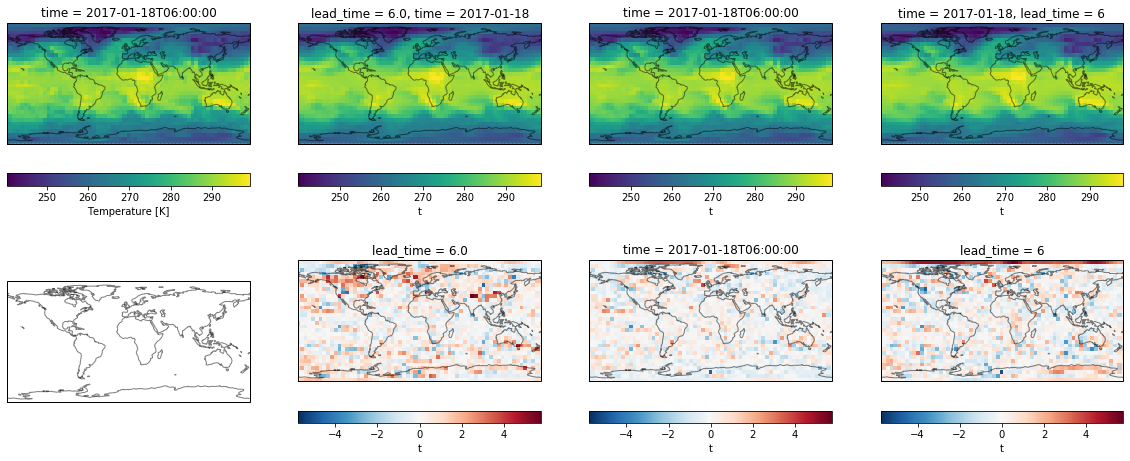

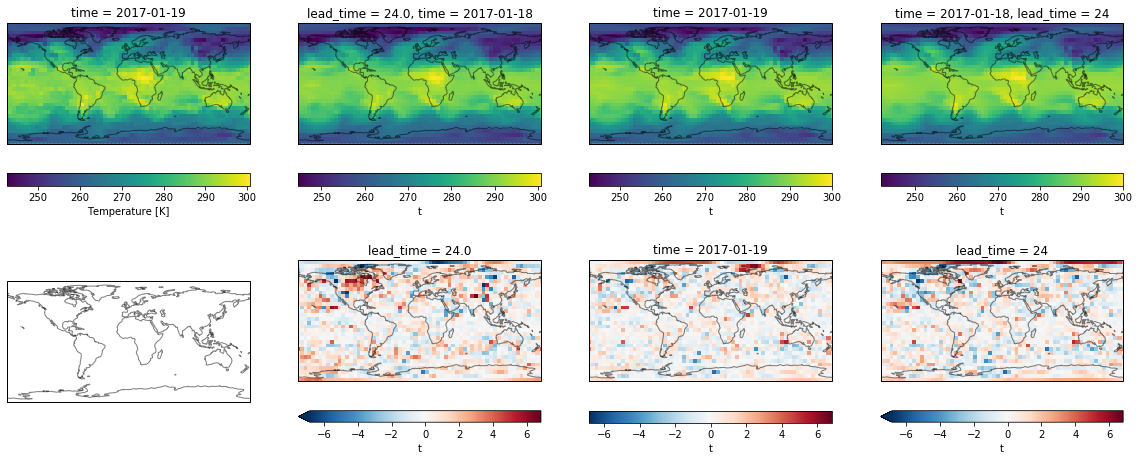

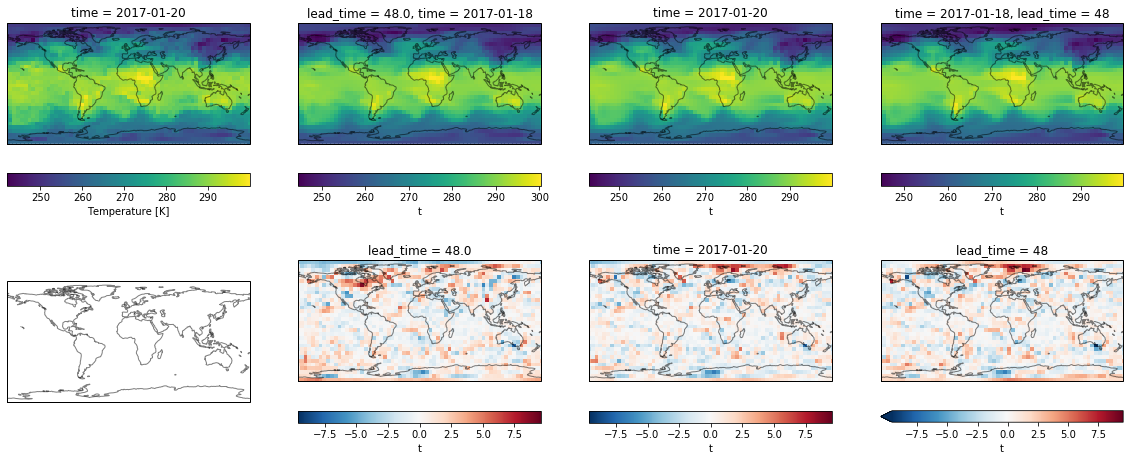

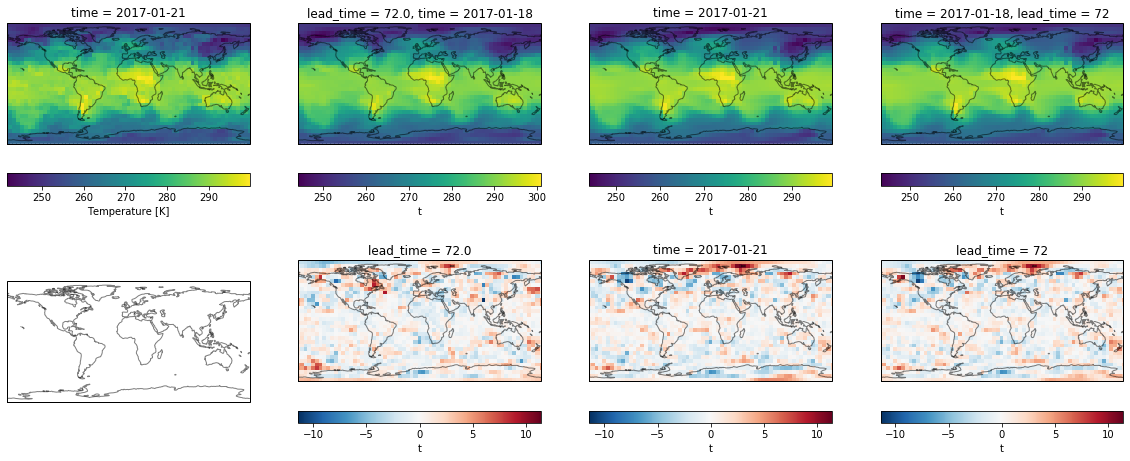

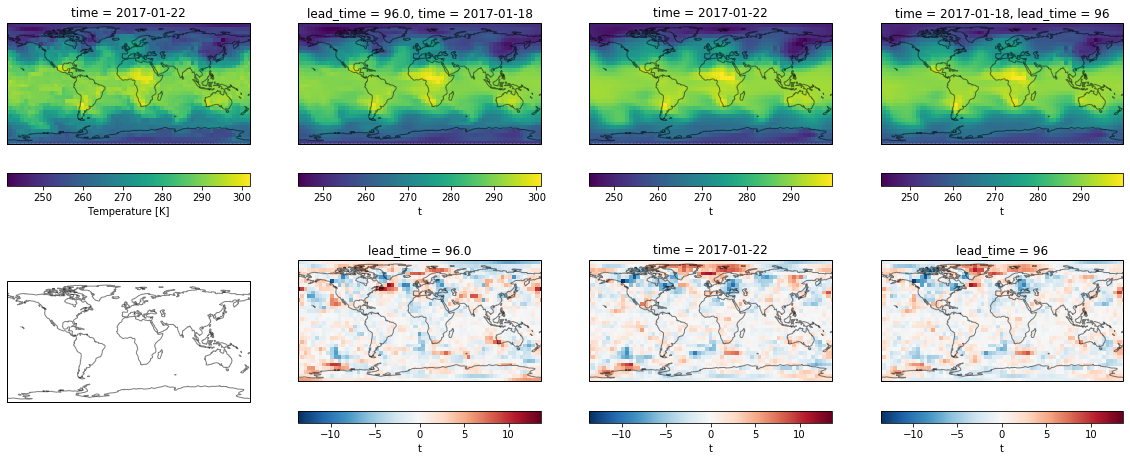

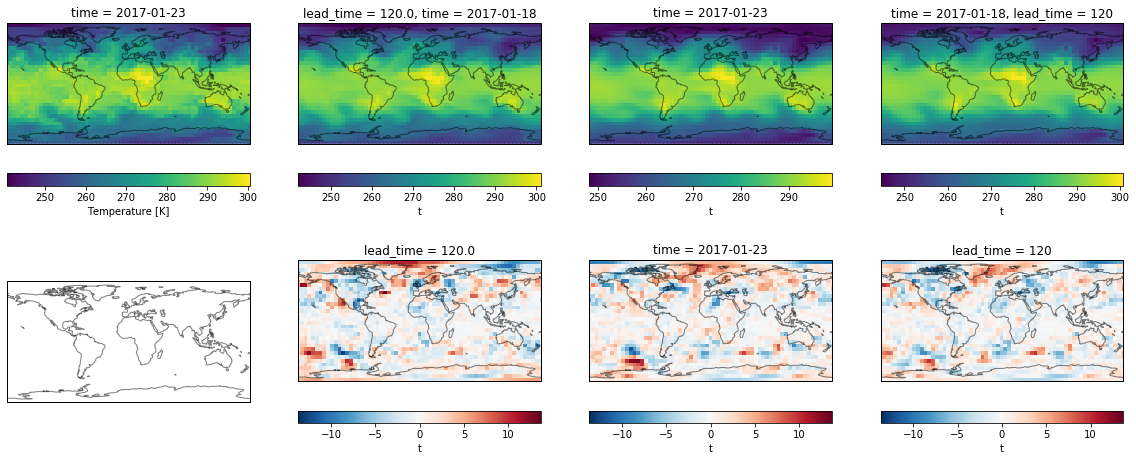

In [229]:
for lt_idx, lt in enumerate(lead_times):
    print(lt)
    valid_time = init_time + np.timedelta64(lt, 'h')
    init_time, valid_time, lt, lt_idx
    var = 't'
    fig, axs = plt.subplots(2, 4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = axs.flatten()
    valid.sel(time=valid_time)[var].plot(ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    preds_weyn.sel(time=init_time, lead_time=lt)[var].plot(ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    preds_direct[lt_idx].sel(time=valid_time)[var].plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
    preds_cont.sel(time=init_time, lead_time=lt)[var].plot(ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})

    e1 = valid.sel(time=valid_time)[var] - preds_weyn.sel(time=init_time, lead_time=lt)[var]
    e2 = valid.sel(time=valid_time)[var] - preds_direct[lt_idx].sel(time=valid_time)[var]
    e3 = valid.sel(time=valid_time)[var] - preds_cont.sel(time=init_time, lead_time=lt)[var]
    m = np.max([e1.max(), e2.max(), e3.max()])
    e1.plot(ax=ax6, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    e2.plot(ax=ax7, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')
    e3.plot(ax=ax8, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, vmin=-m, vmax=m, cmap='RdBu_r')

    for ax in axs.flatten():
            ax.coastlines(alpha=0.5)

In [230]:
rmse_unet2 = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/93-uresnet_5d.nc'), 
            valid,
            mean_dims=['time']
        ).load()

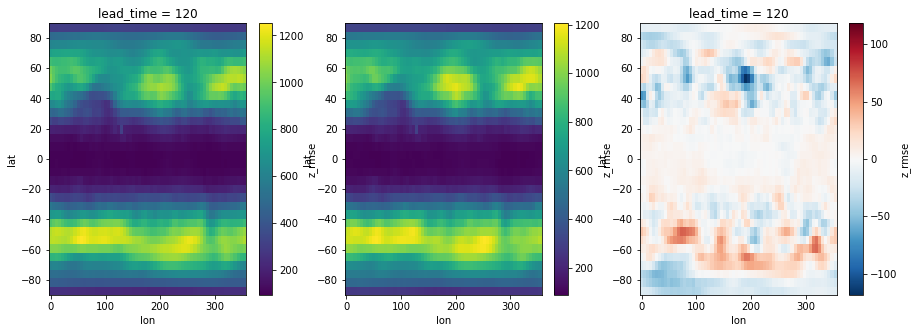

In [237]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
rmse_direct2.sel(lead_time=120).z_rmse.plot(ax=ax1)
rmse_unet2.z_rmse.plot(ax=ax2)
(rmse_direct2.sel(lead_time=120) - rmse_unet2).z_rmse.plot(ax=ax3)

In [166]:
preds_direct[-1].time[:24]

<xarray.DataArray 'time' (time: 24)>
array(['2017-01-06T02:00:00.000000000', '2017-01-06T03:00:00.000000000',
       '2017-01-06T04:00:00.000000000', '2017-01-06T05:00:00.000000000',
       '2017-01-06T06:00:00.000000000', '2017-01-06T07:00:00.000000000',
       '2017-01-06T08:00:00.000000000', '2017-01-06T09:00:00.000000000',
       '2017-01-06T10:00:00.000000000', '2017-01-06T11:00:00.000000000',
       '2017-01-06T12:00:00.000000000', '2017-01-06T13:00:00.000000000',
       '2017-01-06T14:00:00.000000000', '2017-01-06T15:00:00.000000000',
       '2017-01-06T16:00:00.000000000', '2017-01-06T17:00:00.000000000',
       '2017-01-06T18:00:00.000000000', '2017-01-06T19:00:00.000000000',
       '2017-01-06T20:00:00.000000000', '2017-01-06T21:00:00.000000000',
       '2017-01-06T22:00:00.000000000', '2017-01-06T23:00:00.000000000',
       '2017-01-07T00:00:00.000000000', '2017-01-07T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-06T02:00:00 ... 2017-01-07T01:00:00
Attributes:
    long_name:  time

In [88]:
p87 = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/87-resnet_d3_6h_tisr.nc'), 
            valid,
            mean_dims=['time']
        ).load()

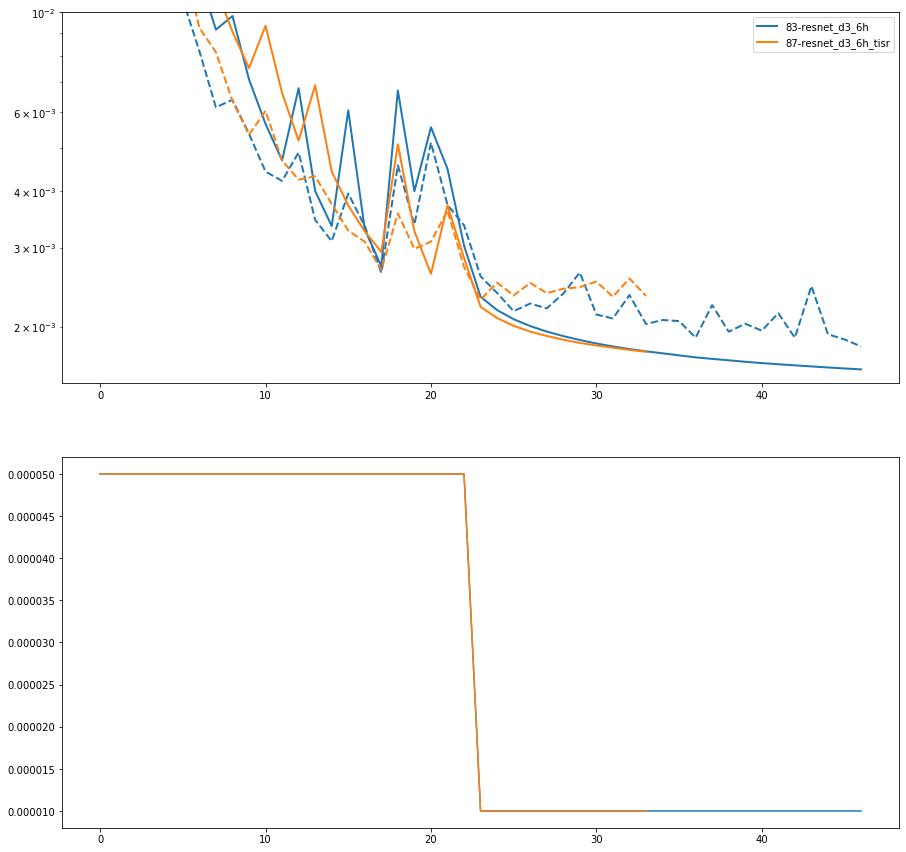

In [100]:
plot_losses('/home/rasp/data/myWeatherBench/predictions/saved_models/', 
            [83, 87], log=True, ylim=(0.0015, 0.01)
        )

In [92]:
p

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t_rmse   float64 0.8248
    z_rmse   float64 83.79

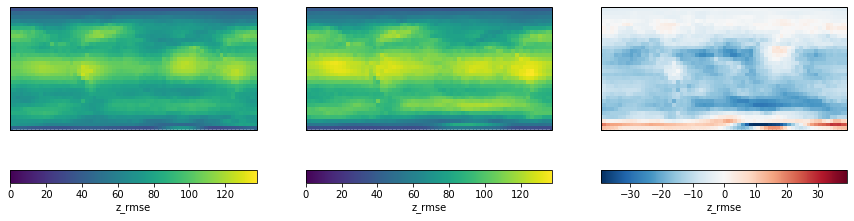

In [93]:
p = preds2[0]
var = 'z_rmse'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
m = np.max([preds[0][var].max(), p87[var].max()])
p[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
p87[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
diff = p[var] - p87[var]
diff.plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})

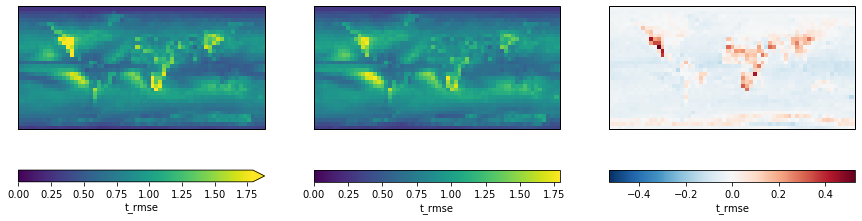

In [94]:
p = preds2[0]
var = 't_rmse'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
m = np.max([preds[0][var].max(), p87[var].max()])
p[var].plot(ax=ax1, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
p87[var].plot(ax=ax2, vmin=0, vmax=m, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})
diff = p[var] - p87[var]
diff.plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})